In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml



Now we want to start tracking particles!
First of all let's load the collider and build the trackers.

Then we want to set the optics from a config file.
We will use the optics from the HL-LHC config.

In [2]:
collider = xt.Multiline.from_json('../data/collider_thin.json')
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
with open('../data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
def set_orbit_from_config(collider, config):
    print('Setting optics as from config')
    for ii in ['on_x1', 'on_sep1', 'on_x2', 'on_sep2', 'on_x5',
               'on_sep5', 'on_x8h', 'on_x8v', 'on_sep8h', 'on_sep8v',
               'on_a1', 'on_o1', 'on_a2', 'on_o2', 'on_a5', 'on_o5', 'on_a8', 
               'on_o8', 'on_disp', 'on_crab1', 'on_crab5', 'on_alice_normalized', 
               'on_lhcb_normalized', 'on_sol_atlas', 'on_sol_cms', 'on_sol_alice', 
               'vrf400', 'lagrf400.b1', 'lagrf400.b2']:
        collider.vars[ii] = config['config_collider']['config_knobs_and_tuning']['knob_settings'][ii]
set_orbit_from_config(collider, config)
twiss_b1 = collider['lhcb1'].twiss()
line = collider['lhcb1']
line.cycle(f"ip1", inplace=True)
''' 
for ii in line.elements:
   # if ii is a type 'multipole' 
   
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0
'''


Setting optics as from config


" \nfor ii in line.elements:\n   # if ii is a type 'multipole' \n   \n    if type(ii) == xt.beam_elements.elements.Multipole:\n        if len(ii.knl)>2:\n            #print(ii)\n            ii.knl[2] = 0\n"

In [4]:
betx = twiss_b1['betx']
#plt.plot(betx)

In [5]:
ctx = xo.ContextCpu()
N_particles = 500
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = line)

*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.07499981826886956
--> Emittance: 2.1273924430340823


In [6]:
import numpy as np
import xpart as xp # To get the right Particles class depending on pyheatail interface state

def generate_matched_gaussian_bunch(num_particles,
                                    nemitt_x, nemitt_y, sigma_z,
                                    total_intensity_particles=None,
                                    particle_on_co=None,
                                    R_matrix=None,
                                    circumference=None,
                                    momentum_compaction_factor=None,
                                    rf_harmonic=None,
                                    rf_voltage=None,
                                    rf_phase=None,
                                    p_increment=0.,
                                    tracker=None,
                                    line=None,
                                    particle_ref=None,
                                    particles_class=None,
                                    engine=None,
                                    _context=None, _buffer=None, _offset=None,
                                    **kwargs, # They are passed to build_particles
                                    ):

    '''
    Generate a matched Gaussian bunch.

    Parameters
    ----------
    line : xpart.Line
        Line for which the bunch is generated.
    num_particles : int
        Number of particles to be generated.
    nemitt_x : float
        Normalized emittance in the horizontal plane (in m rad).
    nemitt_y : float
        Normalized emittance in the vertical plane (in m rad).
    sigma_z : float
        RMS bunch length in meters.
    total_intensity_particles : float
        Total intensity of the bunch in particles.

    Returns
    -------
    part : xpart.Particles
        Particles object containing the generated particles.

    '''

    if line is not None and tracker is not None:
        raise ValueError(
            'line and tracker cannot be provided at the same time.')

    if tracker is not None:
        _print(
            "The argument tracker is deprecated. Please use line instead.",
            DeprecationWarning)
        line = tracker.line

    if line is not None:
        assert line.tracker is not None, ("The line has no tracker. Please use "
                                          "`Line.build_tracker()`")

    if (particle_ref is not None and particle_on_co is not None):
        raise ValueError("`particle_ref` and `particle_on_co`"
                " cannot be provided at the same time")

    if particle_ref is None:
        if particle_on_co is not None:
            particle_ref = particle_on_co
        elif line is not None and line.particle_ref is not None:
            particle_ref = line.particle_ref
        else:
            raise ValueError(
                "`line`, `particle_ref` or `particle_on_co` must be provided!")

    zeta, delta = xp.generate_longitudinal_coordinates(
            distribution='gaussian',
            num_particles=num_particles,
            particle_ref=(particle_ref if particle_ref is not None
                          else particle_on_co),
            line=line,
            circumference=circumference,
            momentum_compaction_factor=momentum_compaction_factor,
            rf_harmonic=rf_harmonic,
            rf_voltage=rf_voltage,
            rf_phase=rf_phase,
            p_increment=p_increment,
            sigma_z=sigma_z,
            engine=engine,
            **kwargs)

    assert len(zeta) == len(delta) == num_particles

    x_norm = np.random.normal(size=num_particles)
    px_norm = np.random.normal(size=num_particles)
    y_norm = np.random.normal(size=num_particles)
    py_norm = np.random.normal(size=num_particles)

    if total_intensity_particles is None:
        # go to particles.weight = 1
        total_intensity_particles = num_particles


    part = xp.build_particles(_context=_context, _buffer=_buffer, _offset=_offset,
                      R_matrix=R_matrix,
                      particles_class=particles_class,
                      particle_on_co=particle_on_co,
                      particle_ref=(
                          particle_ref if particle_on_co is  None else None),
                      line=line,
                      zeta=zeta, delta=delta,
                      x_norm=x_norm, px_norm=px_norm,
                      y_norm=y_norm, py_norm=py_norm,
                      nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                      weight=total_intensity_particles/num_particles,
                      **kwargs)
    return part

Let's plot the bunch in the transverse plane and the histogram of the particles.

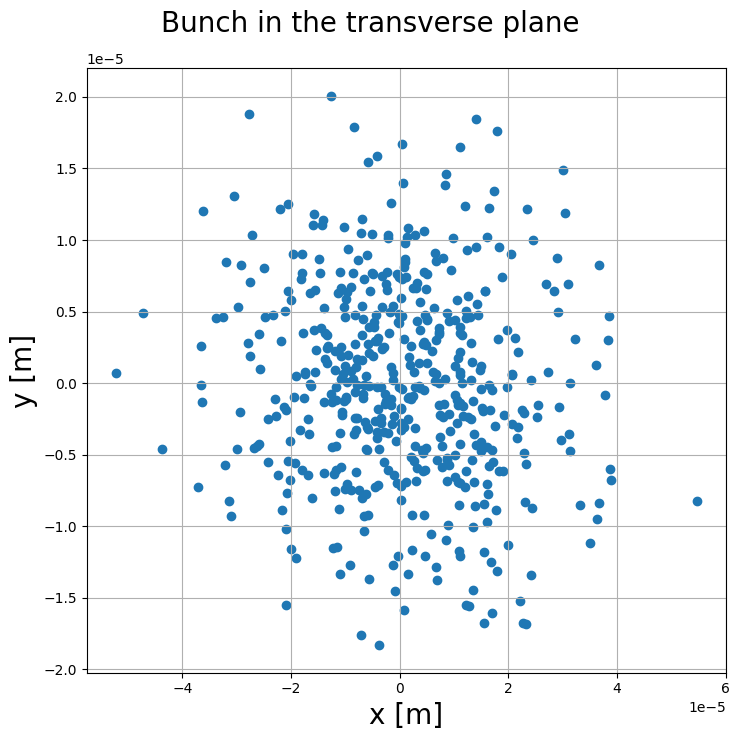

In [7]:
starting_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
starting_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
starting_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7.5, 7.5)
fontsize = 20
fig.suptitle('Bunch in the transverse plane', fontsize = fontsize)
ax.scatter(starting_x, starting_y)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.set_ylabel('y [m]', fontsize = fontsize)
ax.grid()
plt.tight_layout()

(array([ 2.,  1.,  2.,  0.,  1.,  1.,  2.,  5.,  3.,  9.,  7.,  8.,  6.,
         5., 16., 14., 20., 16., 18., 23., 15., 28., 22., 21., 20., 20.,
        17., 25., 23., 20., 23., 10., 19., 19., 11., 14.,  5.,  6.,  6.,
         3.,  1.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  2.]),
 array([-7.27133805e-04, -6.96223596e-04, -6.65313387e-04, -6.34403178e-04,
        -6.03492969e-04, -5.72582760e-04, -5.41672551e-04, -5.10762341e-04,
        -4.79852132e-04, -4.48941923e-04, -4.18031714e-04, -3.87121505e-04,
        -3.56211296e-04, -3.25301087e-04, -2.94390878e-04, -2.63480668e-04,
        -2.32570459e-04, -2.01660250e-04, -1.70750041e-04, -1.39839832e-04,
        -1.08929623e-04, -7.80194136e-05, -4.71092045e-05, -1.61989954e-05,
         1.47112138e-05,  4.56214229e-05,  7.65316320e-05,  1.07441841e-04,
         1.38352050e-04,  1.69262259e-04,  2.00172469e-04,  2.31082678e-04,
         2.61992887e-04,  2.92903096e-04,  3.23813305e-04,  3.54723514e-04,
         3.85633723e-04,  4.1654

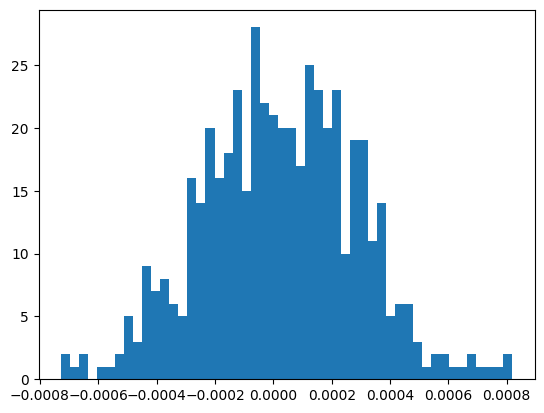

In [14]:
plt.hist(starting_y,
          bins=50)

Let's track the bunch for 10 turns along the collider.

Then we compare the starting and ending distributions. We will see that the distribution changes, as expected.

In [11]:
gamma = float(line.particle_ref.gamma0[0])


In [12]:
N_turns = 1000
line.track(gaussian_bunch, num_turns = N_turns, turn_by_turn_monitor=True)#, freeze_longitudinal=True)

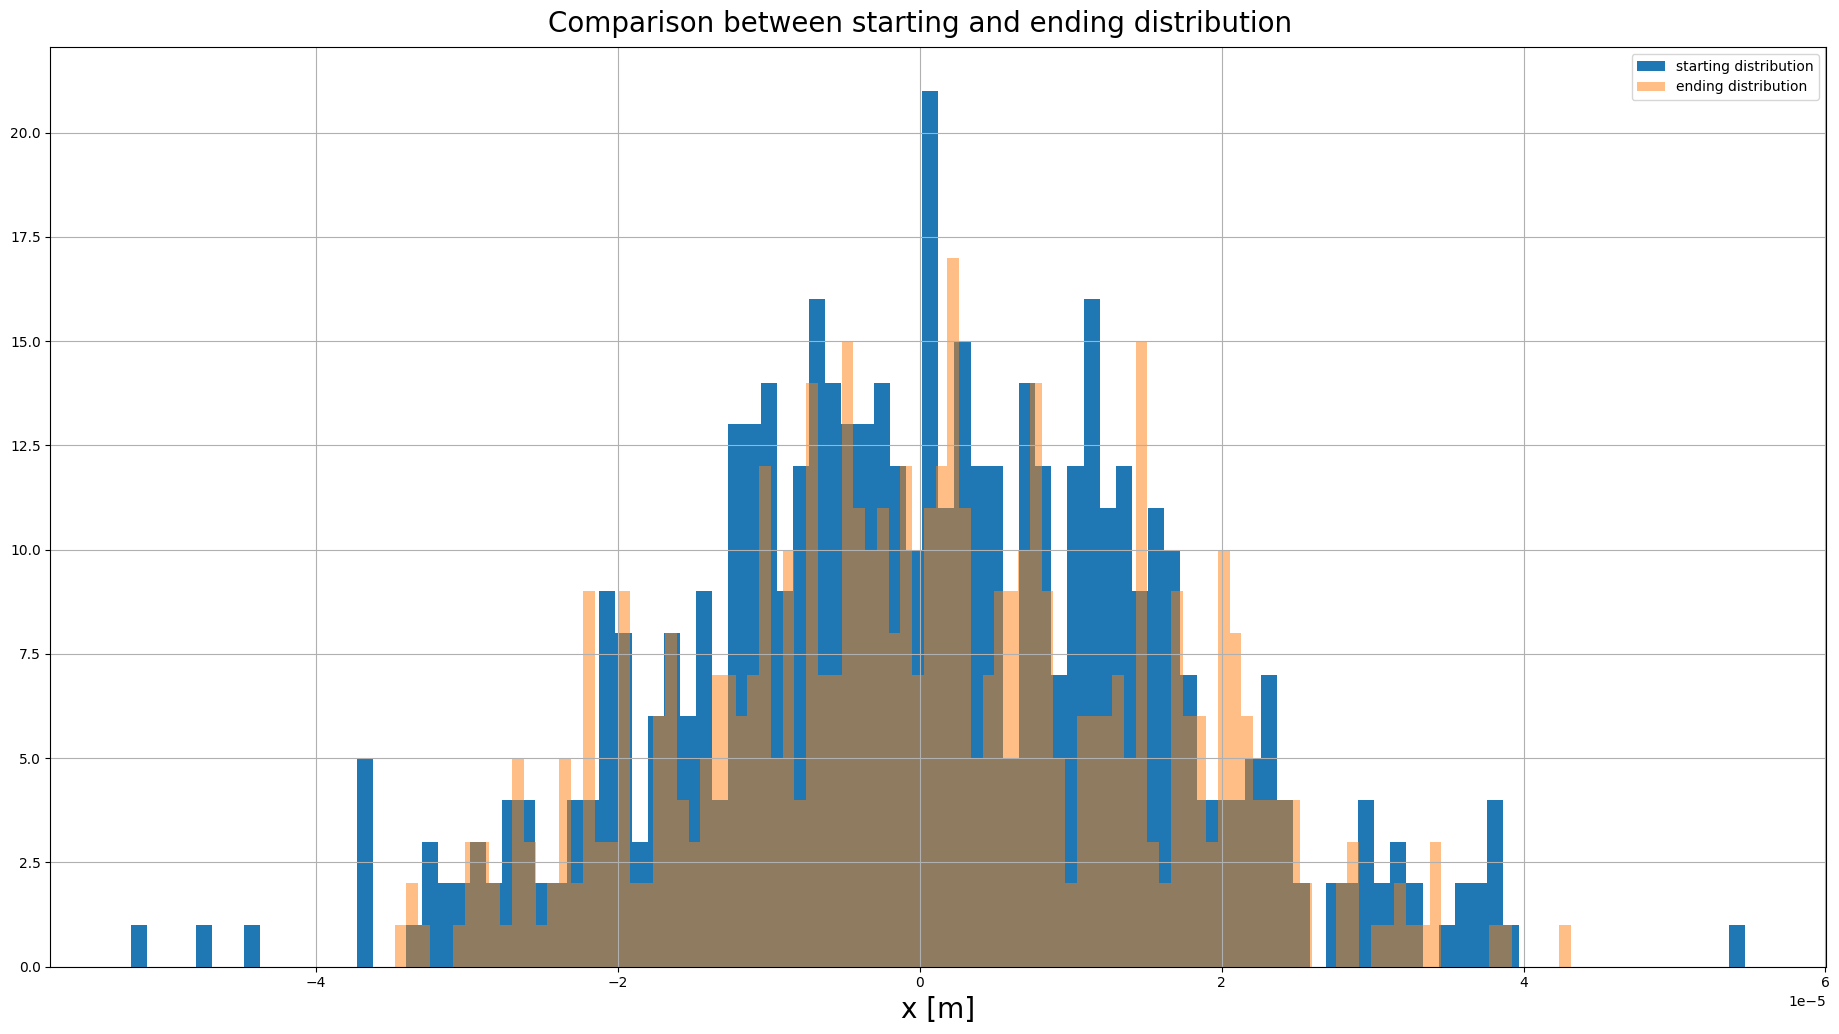

In [13]:
ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Comparison between starting and ending distribution', fontsize = fontsize)
ax.hist(starting_x, bins = 100, label = 'starting distribution')
ax.hist(ending_x, bins = 100, label = 'ending distribution', alpha = 0.5)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.grid()
ax.legend()
plt.tight_layout()

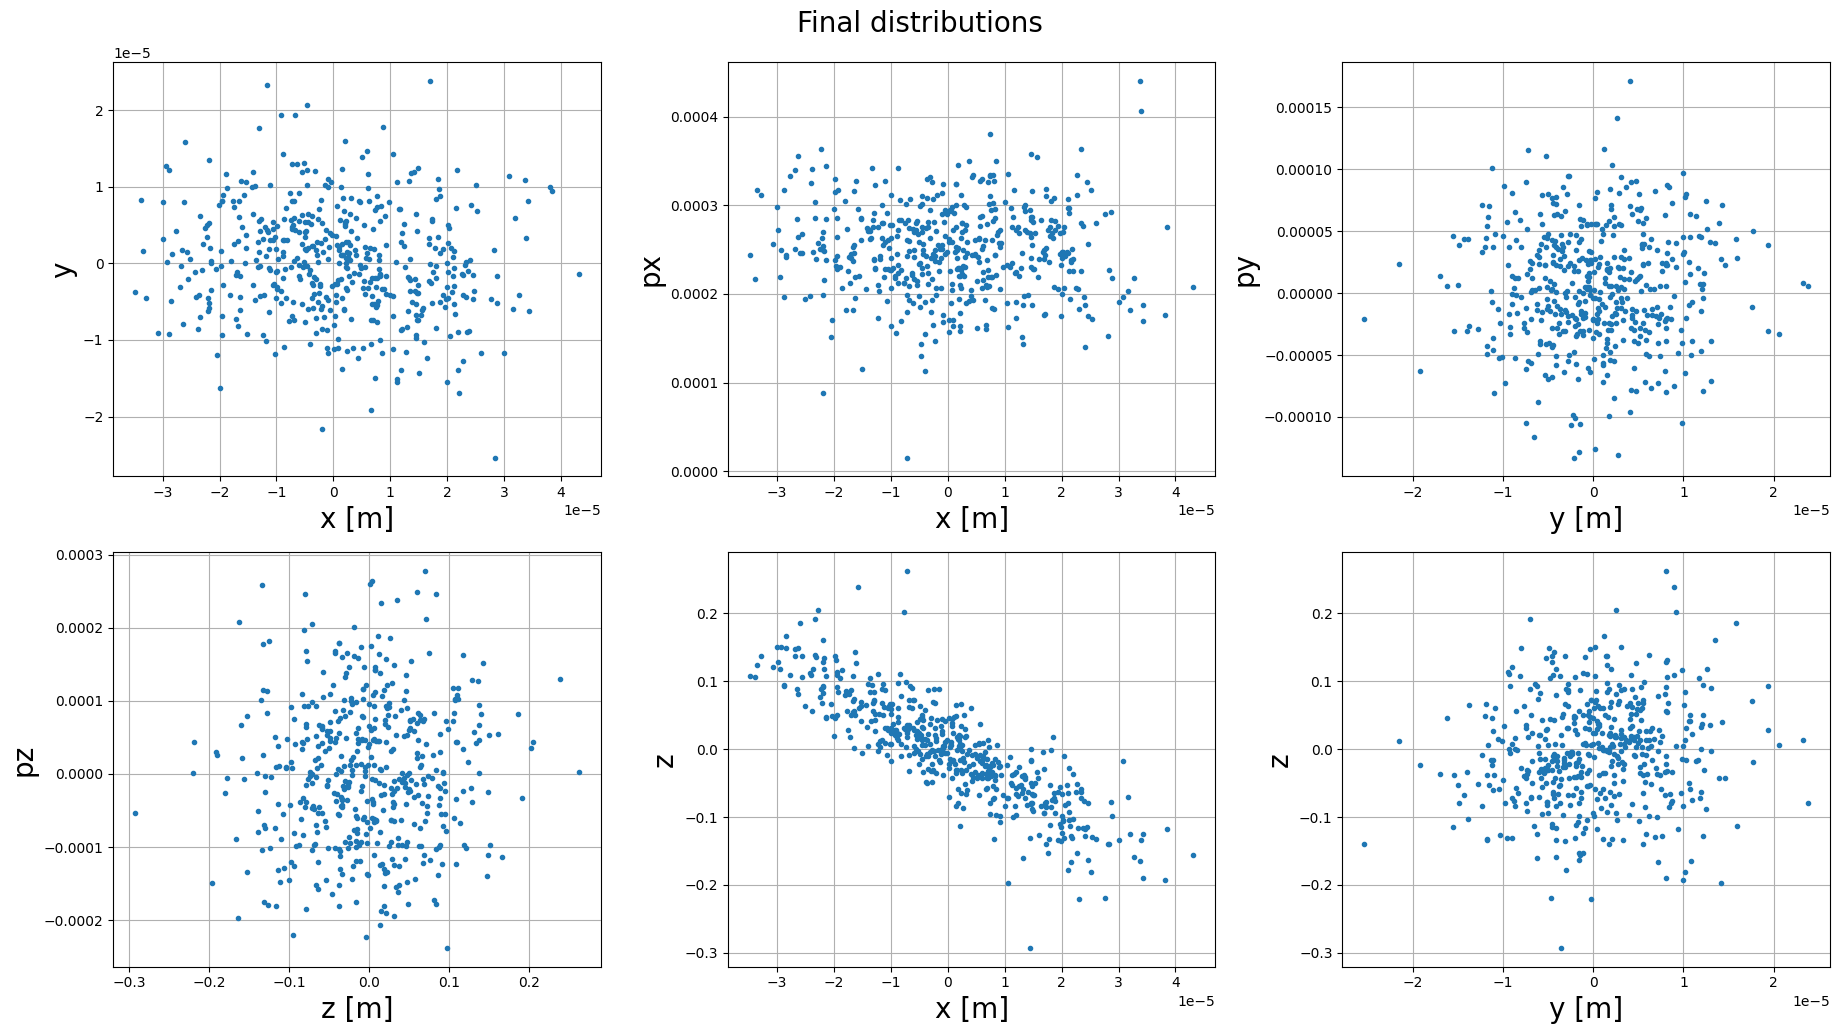

In [14]:
fontsize = 20
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Final distributions' , fontsize = fontsize)


ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()


plt.subplot(2,3,1)
plt.plot(ending_x, ending_y, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('y', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,2)
plt.plot(ending_x, ending_px, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('px', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,3)
plt.plot(ending_y, ending_py, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('py', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,4)
plt.plot(ending_zeta, ending_pz, '.')
plt.xlabel('z [m]', fontsize = fontsize)
plt.ylabel('pz', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,5)
plt.plot(ending_x, ending_zeta, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,6)
plt.plot(ending_y, ending_zeta, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()




plt.tight_layout()

In [15]:
x_data = collider['lhcb1'].record_last_track.x
y_data = collider['lhcb1'].record_last_track.y
px_data = collider['lhcb1'].record_last_track.px
py_data = collider['lhcb1'].record_last_track.py
zeta_data = collider['lhcb1'].record_last_track.zeta
pz_data = collider['lhcb1'].record_last_track.pzeta
print(x_data.shape)

(500, 1000)


In [16]:
len(betx)

23701

-0.30350554711023675 0.3034945220191234


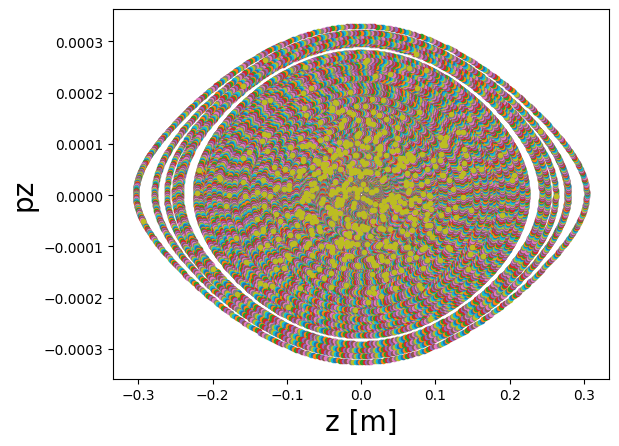

In [17]:
#for i in range(len(x_data[0:1000])):
for i in range(len(x_data.T)-1):
   plt.plot(zeta_data.T[i], pz_data.T[i], '.')
plt.xlabel('z [m]', fontsize = fontsize)
plt.ylabel('pz', fontsize = fontsize)
#plt.xlim(zeta_data.flatten().min(), zeta_data.flatten().max())
#plt.ylim(pz_data.flatten().min(), pz_data.flatten().max())
#plt.axvline(0.2, color = 'red')
print(zeta_data.flatten().min(), zeta_data.flatten().max())

## Emmitance one snapshot


1.591915867446697e-05 0.000253563965621045 4.036384264614379e-09
1.314306403789153e-05 0.00025600660811343296 3.360867133643084e-09
1.22203587797613e-05 0.00025492462625000906 3.1143832820793425e-09
1.5559788922617997e-05 0.0002537560709724611 3.946077930083779e-09
1.4025749670986156e-05 0.00025574163760389 3.5816064709424724e-09
1.1972276344386446e-05 0.00025492227616777136 3.0519163442557994e-09
1.4836250701548754e-05 0.0002542682431607493 3.767506280688086e-09
1.4912097225441721e-05 0.00025505359425291563 3.79881515826853e-09
1.1989578726095561e-05 0.00025514763232997663 3.0590122741235398e-09
1.3937999479593722e-05 0.00025475923629325804 3.545565341788591e-09
1.5586969552303087e-05 0.000254246353306874 3.9610471277494735e-09
1.2270475005135058e-05 0.00025555582178216925 3.134872517025989e-09
1.3087796156876618e-05 0.0002549877887683675 3.333721292530465e-09
1.5879681055508035e-05 0.00025371508149606034 4.028873618746989e-09
1.2825227861685678e-05 0.00025589786834310596 3.2793128940

1000

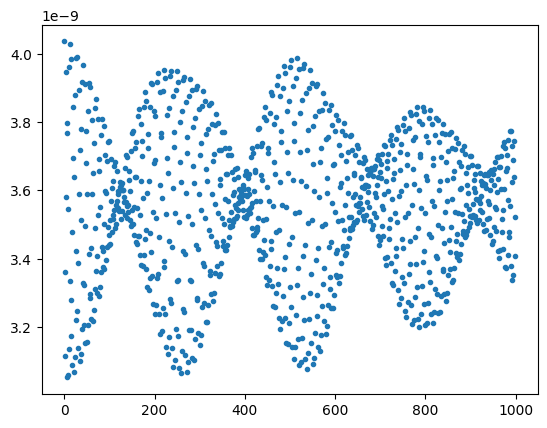

In [18]:
# Emittance
emit_x_all = []
for i in range(len(x_data.T)):

    rms_x = np.sqrt(np.mean(x_data.T[i]**2))
    rms_y = np.sqrt(np.mean(y_data.T[i]**2))
    rms_z = np.sqrt(np.mean(zeta_data.T[i]**2))
    rms_px = np.sqrt(np.mean(px_data.T[i]**2))
    rms_py = np.sqrt(np.mean(py_data.T[i]**2))
    rms_pz = np.sqrt(np.mean(pz_data.T[i]**2))



    cov_matrix_x = np.cov(x_data.T[i], px_data.T[i])
    cov_matrix_y = np.cov(y_data.T[i], py_data.T[i])
    cov_matrix_z = np.cov(zeta_data.T[i], pz_data.T[i])
    cross_term_x = cov_matrix_x[0,1]
    cross_term_y = cov_matrix_y[0, 1]
    cross_term_z = cov_matrix_z[0, 1]
    # Compute the emittance using RMS values and the cross-correlation term
    emit_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cross_term_x ** 2)
    emit_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cross_term_y ** 2)
    emit_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cross_term_z ** 2)

    emit_x_all.append(emit_x)
    
    print(rms_x, rms_px, emit_x)

plt.plot(emit_x_all, '.')
len(emit_x_all)



In [23]:
collider.lhcb1.twiss().to_pandas().iloc[0]["dx"]

-0.0012154314911169224

Emittance in x-direction: 6.674297931688185e-10
Emittance in y-direction: 3.291302570288131e-10


Text(0, 0.5, 'Emittance total')

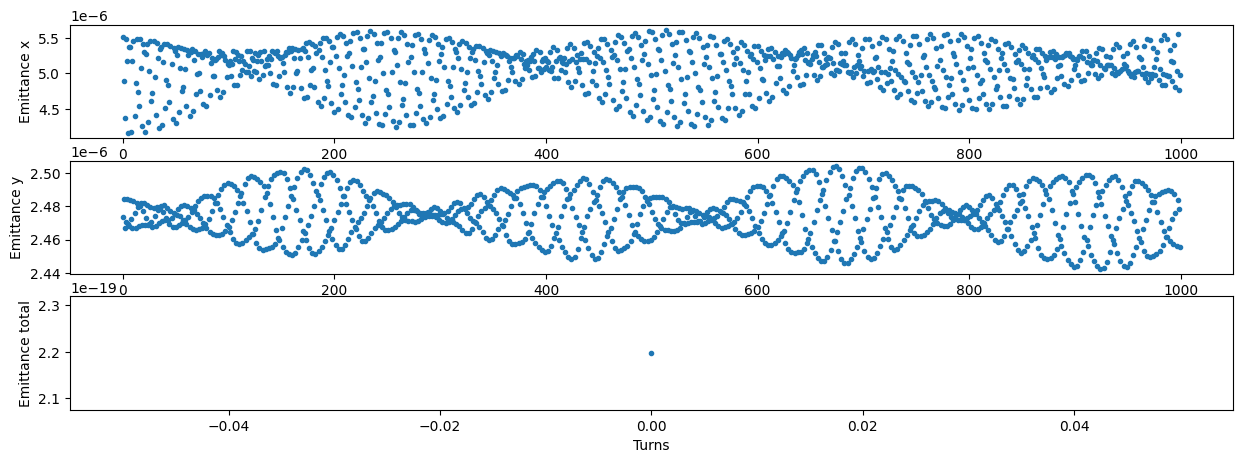

In [19]:
import numpy as np

# Assuming x_data, y_data, z_data, px_data, py_data, pz_data are arrays/lists containing respective data
emittance_x_all = []
emittance_y_all = []
emittance_z_all = []
total_all = []
# Calculate mean values for x, y, z, px, py, pz
for i in range(len(x_data.T)):
    mean_x = np.mean(x_data.T[i])
    mean_y = np.mean(y_data.T[i])
    mean_z = np.mean(zeta_data.T[i])
    mean_px = np.mean(px_data.T[i])
    mean_py = np.mean(py_data.T[i])
    mean_pz = np.mean(pz_data.T[i])

    # Calculate RMS values for x, y, z, px, py, pz
    rms_x = np.sqrt(np.mean(np.square(x_data.T[i] - mean_x)))
    rms_y = np.sqrt(np.mean(np.square(y_data.T[i] - mean_y)))
    rms_z = np.sqrt(np.mean(np.square(zeta_data.T[i] - mean_z)))
    rms_px = np.sqrt(np.mean(np.square(px_data.T[i] - mean_px)))
    rms_py = np.sqrt(np.mean(np.square(py_data.T[i] - mean_py)))
    rms_pz = np.sqrt(np.mean(np.square(pz_data.T[i] - mean_pz)))

    # Calculate the covariance matrix for position and momentum
    data_matrix = np.array([x_data.T[i], y_data.T[i], zeta_data.T[i], px_data.T[i], py_data.T[i], pz_data.T[i]])
    cov_matrix = np.cov(data_matrix)

    # Extract the covariance terms between different dimensions
    cov_x_px = cov_matrix[0, 3]  # Covariance between x and px
    cov_y_py = cov_matrix[1, 4]  # Covariance between y and py
    cov_z_pz = cov_matrix[2, 5]  # Covariance between z and pz

    # Compute emittance in each direction
    emittance_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2)
    emittance_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)
    #emittance_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)
    total_emittance = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2) * np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)#* np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)

    emittance_x_all.append(emittance_x*gamma)
    emittance_y_all.append(emittance_y*gamma)
    #emittance_z_all.append(emittance_z)
    total_all.append(total_emittance)


print("Emittance in x-direction:", emittance_x)
print("Emittance in y-direction:", emittance_y)
#print("Emittance in z-direction:", emittance_z)


plt.figure(figsize=(15, 5))
plt.subplot(3,1,1)
plt.xlabel('Turns')
plt.ylabel('Emittance x')
plt.plot(emittance_x_all, '.')
plt.subplot(3,1,2)
plt.plot(emittance_y_all, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance y')
plt.subplot(3,1,3)
plt.plot(total_emittance, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance total')


In [20]:
import PyNAFF
qx_i = []
qy_i = []
for ii in range(len(x_data.T[0])):
    qx_i.append(PyNAFF.naff(x_data[ii,:], turns=N_turns-1)[0][1])
    qy_i.append(PyNAFF.naff(y_data[ii,:], turns=N_turns-1)[0][1])

Indices for filtered_values_x: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223,

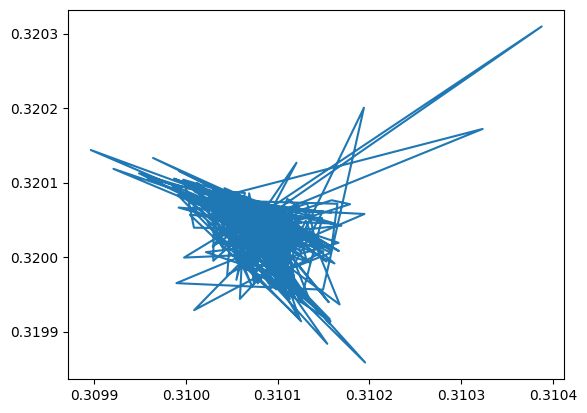

In [19]:
filtered_values_x = list(filter(lambda x: x > 0.2, qx_i))
filtered_values_y = list(filter(lambda x: x > 0.2, qy_i))
#plt.plot(filtered_values_x, filtered_values_y)
indices_x = [i for i, val in enumerate(qx_i) if val > 0.2]
indices_y = [i for i, val in enumerate(qy_i) if val > 0.2]

print("Indices for filtered_values_x:", indices_x)
print("Indices for filtered_values_y:", indices_y)
common_indices = list(set(indices_x).intersection(indices_y))

values_from_qx_i = [qx_i[idx] for idx in common_indices]
values_from_qy_i = [qy_i[idx] for idx in common_indices]
plt.plot(values_from_qx_i, values_from_qy_i)

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


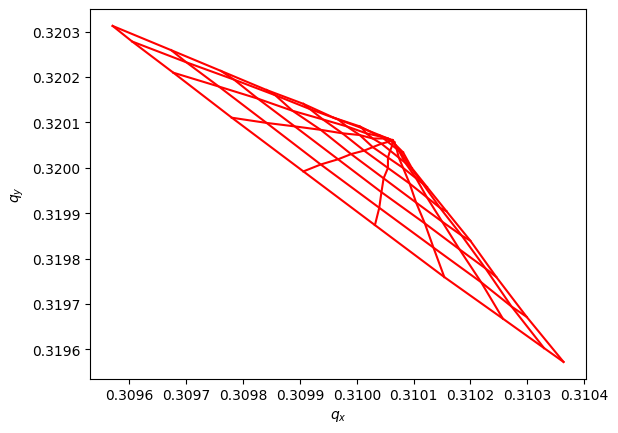

In [20]:
fp0_jgrid = collider['lhcb1'].get_footprint(nemitt_x=normal_emitt_x, nemitt_y=normal_emitt_y,
                            mode='polar')
fp0_jgrid.plot(color='red')

In [21]:
len(zeta_data.T)
std_x = np.std(x_data.T[0])
std_y = np.std(y_data.T[0])
std_z = np.std(zeta_data.T[0])
std_px = np.std(px_data.T[0])
std_py = np.std(py_data.T[0])
std_pz = np.std(pz_data.T[0])

cov_x_xp = np.cov(x_data.T[0], px_data.T[0])[0][1]
cov_y_yp = np.cov(y_data.T[0], py_data.T[0])[0][1]
cov_z_zp = np.cov(zeta_data.T[0], pz_data.T[0])[0][1]
cov_x_z = np.cov(x_data.T[0], zeta_data.T[0])[0][1]
cov_y_z = np.cov(y_data.T[0], zeta_data.T[0])[0][1]
cov_pz_py = np.cov(pz_data.T[0], py_data.T[0])[0][1]

# Emittance
emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
print('Emmitance: ', emitt)


Emmitance:  7.39759177112198e-06


Text(0, 0.5, 'Emittance $\\epsilon $')

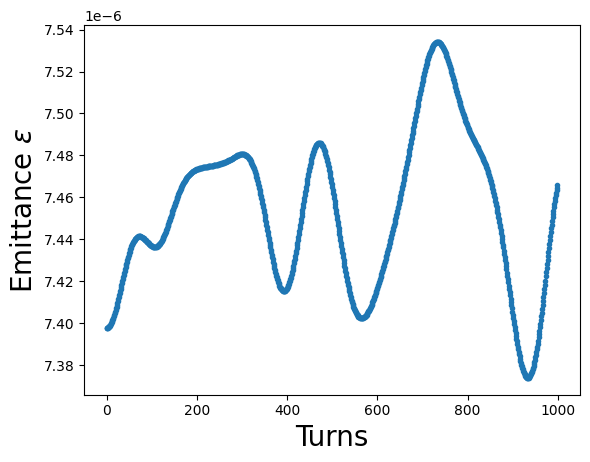

In [22]:
emitt_all = []
for i in range(len(x_data.T)):
    std_x = np.std(x_data.T[i])
    std_y = np.std(y_data.T[i])
    std_z = np.std(zeta_data.T[i])
    std_px = np.std(px_data.T[i])
    std_py = np.std(py_data.T[i])
    std_pz = np.std(pz_data.T[i])

    # That is for the correlation between the planes
    cov_x_xp = np.cov(x_data.T[i], px_data.T[i])[0][1]   
    cov_x_z = np.cov(x_data.T[i], zeta_data.T[i])[0][1]
    cov_y_z = np.cov(y_data.T[i], zeta_data.T[i])[0][1]

    # Emittance
    emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
    emitt_all.append(emitt)

plt.plot(emitt_all, '.')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance $\epsilon $', fontsize = fontsize)

499


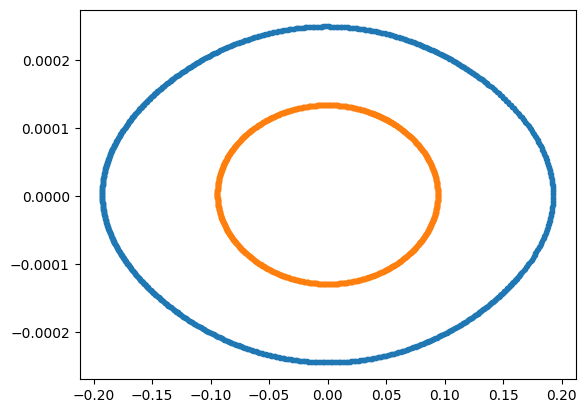

In [23]:

plt.plot(zeta_data[0], pz_data[0].T, '.')
plt.plot(zeta_data[1], pz_data[1].T, '.')

print(len(x_data)-1)

KeyboardInterrupt: 

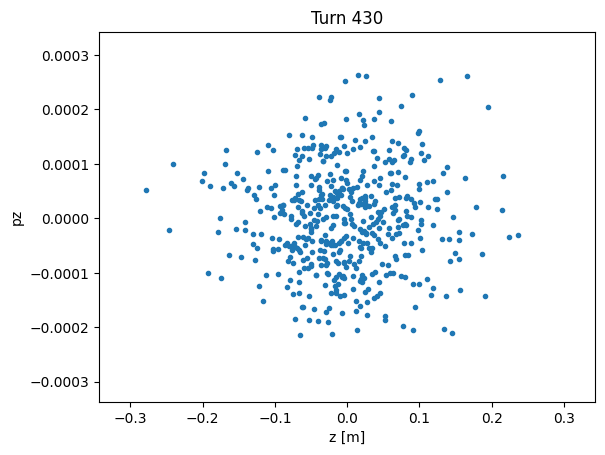

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Generating example data (replace this with your actual data)
num_points = 100
num_snapshots = 10
x_min = min(x_data.flatten())
x_max = max(x_data.flatten())
px_min = min(px_data.flatten())
px_max = max(px_data.flatten())
y_min = min(y_data.flatten())
y_max = max(y_data.flatten())
py_min = min(py_data.flatten())
py_max = max(py_data.flatten())
z_min = min(zeta_data.flatten())
z_max = max(zeta_data.flatten())
pz_min = min(pz_data.flatten())
pz_max = max(pz_data.flatten())



# Plot and save each frame as an image
images = []
for i in range(len(x_data[:])):
    plt.plot(zeta_data.T[i], pz_data.T[i], '.')
    plt.title(f"Turn {i}")
    plt.xlabel('z [m]')
    plt.ylabel('pz')
    plt.savefig(f"images/frame_{i}.png")  # Save each frame as an image
    plt.clf()  # Clear the plot for the next frame
    plt.xlim(z_min, z_max)
    plt.ylim(pz_min, pz_max)
    # Open the saved image and append it to the list of images
    img = Image.open(f"images/frame_{i}.png")
    images.append(img)

# Save the images as an animated GIF
images[0].save('animation_zeta_pz_1000turns_time.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)


In [ ]:
#images[0].save('animation_zeta_pz_1000turns.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

NameError: name 'np' is not defined